In [69]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [70]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [71]:
NUM_CLASSES = 5

# Dataset reading

In [72]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [73]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [76]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 5)                 55        
                                                                 
Total params: 1125 (4.39 KB)
Trainable params: 1125 (4.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [78]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [79]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


 1/37 [..............................] - ETA: 19s - loss: 1.6475 - accuracy: 0.1641
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.h5
37/37 [==============================] - 1s 6ms/step - loss: 1.5862 - accuracy: 0.2017 - val_loss: 1.4816 - val_accuracy: 0.4391
Epoch 2/1000
 1/37 [..............................] - ETA: 0s - loss: 1.5154 - accuracy: 0.2344
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.h5
37/37 [==============================] - 0s 3ms/step - loss: 1.4493 - accuracy: 0.3512 - val_loss: 1.3003 - val_accuracy: 0.7024
Epoch 3/1000
 1/37 [..............................] - ETA: 0s - loss: 1.3906 - accuracy: 0.4531

c:\Users\zeins\anaconda3\envs\lsl\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.h5
37/37 [==============================] - 0s 3ms/step - loss: 1.2683 - accuracy: 0.5533 - val_loss: 1.0056 - val_accuracy: 0.9423
Epoch 4/1000
 1/37 [..............................] - ETA: 0s - loss: 1.2129 - accuracy: 0.5547
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.h5
37/37 [==============================] - 0s 3ms/step - loss: 1.0667 - accuracy: 0.6299 - val_loss: 0.7365 - val_accuracy: 0.9873
Epoch 5/1000
 1/37 [..............................] - ETA: 0s - loss: 0.9874 - accuracy: 0.6328
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.h5
37/37 [==============================] - 0s 3ms/step - loss: 0.8826 - accuracy: 0.6985 - val_loss: 0.5376 - val_accuracy: 0.9949
Epoch 6/1000
 1/37 [..............................] - ETA: 0s - loss: 0.8286 - accuracy: 0.7188
Epoch 6: saving model to model/keypoint_classifier\keypoint_classifier.h5
37/37 [=====================

In [80]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 1ms/step - loss: 0.0112 - accuracy: 1.0000


In [81]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [82]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 46ms/step
[3.1242561e-02 9.6859390e-01 8.4332887e-06 1.1876857e-04 3.6267644e-05]
1


# Confusion matrix

50/50 [==============================] - 0s 811us/step


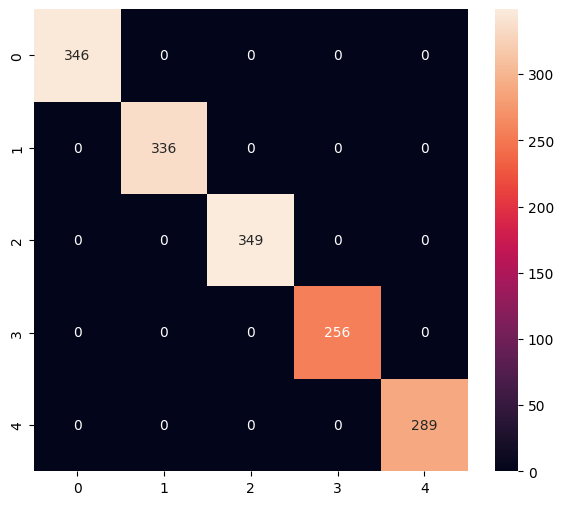

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       336
           2       1.00      1.00      1.00       349
           3       1.00      1.00      1.00       256
           4       1.00      1.00      1.00       289

    accuracy                           1.00      1576
   macro avg       1.00      1.00      1.00      1576
weighted avg       1.00      1.00      1.00      1576



In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [84]:
# Save as a model dedicated to inference
model.save(model_save_path)

c:\Users\zeins\anaconda3\envs\lsl\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmp1s_0u9t1\assets


INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmp1s_0u9t1\assets


6652

# Inference test

In [86]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [87]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [88]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [89]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.12425960e-02 9.68593895e-01 8.43328780e-06 1.18768556e-04
 3.62676801e-05]
1
CPU times: total: 0 ns
Wall time: 0 ns
